## Handwrtten Digits Identification with MNIST Database

Task: Train a module to identify the handwrtten digits

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import joblib
import os
from PIL import Image


### Read MNIST Dataset Class from kaggle

### 1.Data Loading

### Saving img into Data folder, as Training dataset and validation dataset 

In [1]:
import os
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from PIL import Image

# Fetch the MNIST data
imgdata = fetch_openml("mnist_784", as_frame=False)

# Extract images and labels
images, labels = imgdata.data, imgdata.target

# Split the data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.05, random_state=42)

# Create base directories for train and test data
data_base_dir = 'data/mint/'
train_dir = os.path.join(data_base_dir, 'train')
test_dir = os.path.join(data_base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to save images in subfolders based on labels
def save_images(images, labels, base_dir):
    for idx, image in enumerate(images):
        # Reshape the flat array into a 28x28 matrix
        img_matrix = image.reshape(28, 28).astype(np.uint8)

        # Create a PIL Image object
        img = Image.fromarray(img_matrix, mode='L')

        # Get the label and create a subfolder for the label if it doesn't exist
        label = labels[idx]
        label_dir = os.path.join(base_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Construct the filename
        filename = os.path.join(label_dir, f"image_{idx}.png")

        # Save the image
        img.save(filename)

        # Optional: Print progress
        if idx % 1000 == 0:
            print(f"Saved {idx} images to {base_dir}...")

# Save train and test images in their respective directories
save_images(train_images, train_labels, train_dir)
save_images(test_images, test_labels, test_dir)

print("All train and test images have been saved.")


Saved 0 images to data/mint/train...
Saved 1000 images to data/mint/train...
Saved 2000 images to data/mint/train...
Saved 3000 images to data/mint/train...
Saved 4000 images to data/mint/train...
Saved 5000 images to data/mint/train...
Saved 6000 images to data/mint/train...
Saved 7000 images to data/mint/train...
Saved 8000 images to data/mint/train...
Saved 9000 images to data/mint/train...
Saved 10000 images to data/mint/train...
Saved 11000 images to data/mint/train...
Saved 12000 images to data/mint/train...
Saved 13000 images to data/mint/train...
Saved 14000 images to data/mint/train...
Saved 15000 images to data/mint/train...
Saved 16000 images to data/mint/train...
Saved 17000 images to data/mint/train...
Saved 18000 images to data/mint/train...
Saved 19000 images to data/mint/train...
Saved 20000 images to data/mint/train...
Saved 21000 images to data/mint/train...
Saved 22000 images to data/mint/train...
Saved 23000 images to data/mint/train...
Saved 24000 images to data/mi

### Glance the data

10 classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


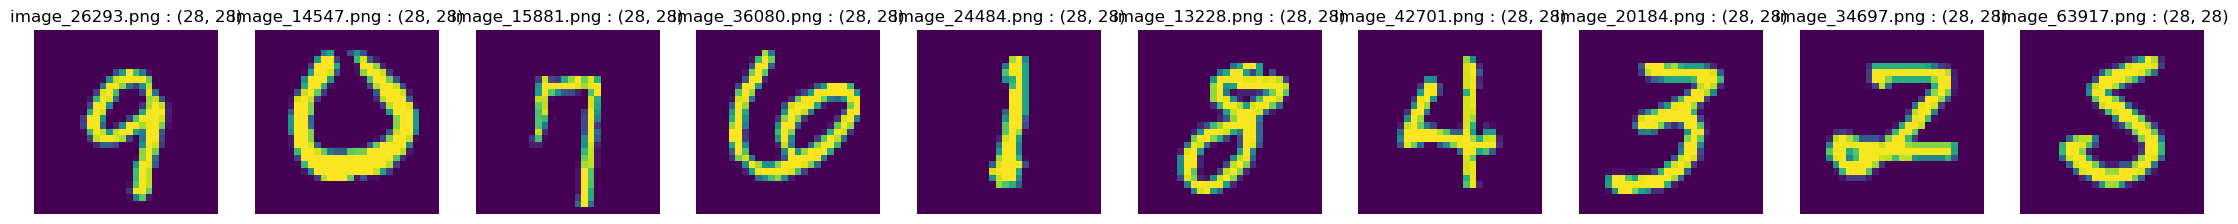

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# The images are in the data/shapes folder
data_path = 'data/mint/train'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(28, 28))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

## Data explortation

## PyTorch Setup

In [4]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.5.1


### Create data loaders

### Data Normalization and split train and test

In [5]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


## Define CNN module

In [18]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=28, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=28, out_channels=14, kernel_size=3, stride=1, padding=1)

        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=14, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 200x200 image tensors will be pooled twice with a kernel size of 2. 200/2/2 is 50.
        # So our feature tensors are now 50 x 50, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=14 * 14 * 10, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.conv2(x))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        # x = F.relu(self.drop(self.conv3(x)))
        x = F.relu(self.conv3(x))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 14 * 14 * 10)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


## Train the model


In [8]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs
epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/53200 (0%)] Loss: 2.296806
Training set [500/53200 (1%)] Loss: 2.207282
Training set [1000/53200 (2%)] Loss: 1.693499
Training set [1500/53200 (3%)] Loss: 1.113857
Training set [2000/53200 (4%)] Loss: 0.827220
Training set [2500/53200 (5%)] Loss: 0.600900
Training set [3000/53200 (6%)] Loss: 0.809361
Training set [3500/53200 (7%)] Loss: 0.658740
Training set [4000/53200 (8%)] Loss: 0.321170
Training set [4500/53200 (8%)] Loss: 0.458617
Training set [5000/53200 (9%)] Loss: 0.465345
Training set [5500/53200 (10%)] Loss: 0.702548
Training set [6000/53200 (11%)] Loss: 0.383501
Training set [6500/53200 (12%)] Loss: 0.266761
Training set [7000/53200 (13%)] Loss: 0.239723
Training set [7500/53200 (14%)] Loss: 0.332622
Training set [8000/53200 (15%)] Loss: 0.290393
Training set [8500/53200 (16%)] Loss: 0.193918
Training set [9000/53200 (17%)] Loss: 0.215953
Training set [9500/53200 (18%)] Loss: 0.276197
Training set [10000/53200 (19%)] Loss: 0.284979
Tr

## Review training and validation loss


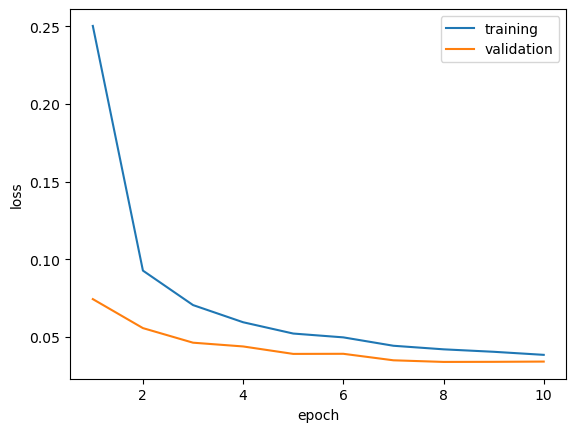

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...
Overall Accuracy: 0.9903007518796992
Overall Precision: 0.9903219482613392
Overall Recall: 0.9901177251441858


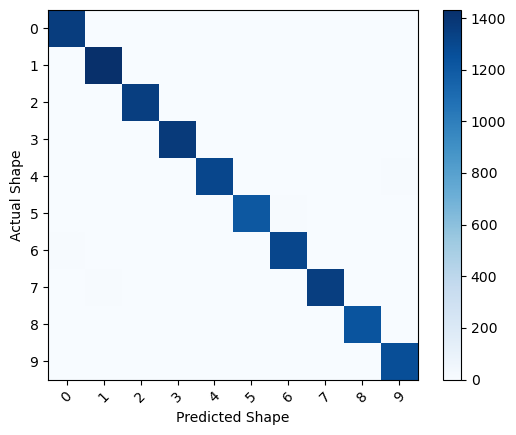

In [17]:
from sklearn. metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix



# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Get metrics
print("Overall Accuracy:",accuracy_score(truelabels, predictions))
print("Overall Precision:",precision_score(truelabels, predictions, average='macro'))
print("Overall Recall:",recall_score(truelabels, predictions, average='macro'))


# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## ROC / AUC 

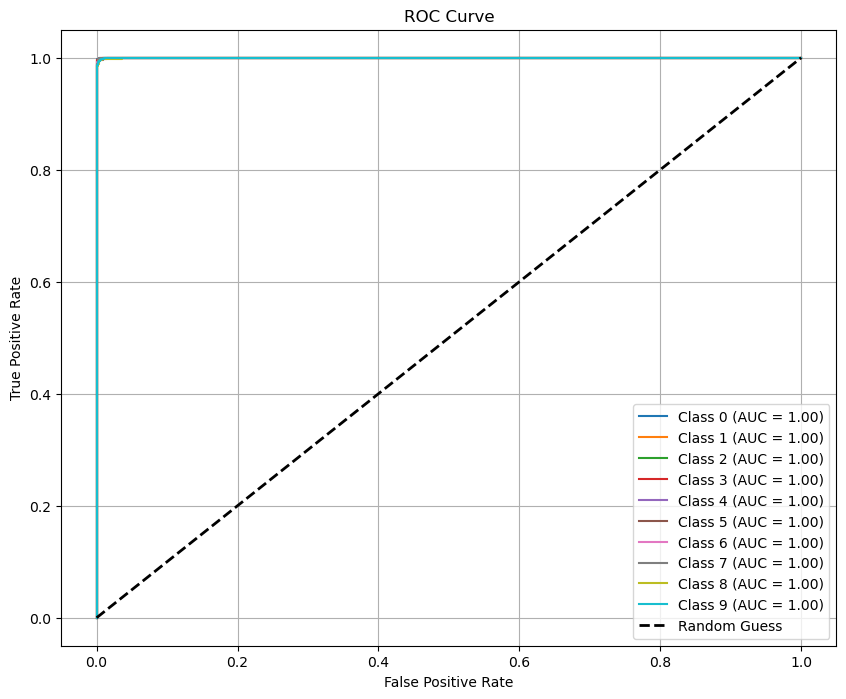

In [11]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming `test_loader` contains the test data and true labels

def plot_roc_curve(model, device, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get model outputs
            output = model(data)
            
            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(output, dim=1)
            
            # Store true labels and probabilities
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert targets and predictions to numpy arrays
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    # One-hot encode the true labels
    all_targets_onehot = label_binarize(all_targets, classes=np.arange(num_classes))
    
    # Calculate ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_targets_onehot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(model, device, test_loader, num_classes=len(classes))


### Save model

In [12]:
# Save the model weights
model_file = 'P01 - CNN.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as P01 - CNN.pt


### Load model

In [ ]:


model_file = 'P01 - CNN.pt'
# Load your model
model = Net()
model.load_state_dict(torch.load(model_file))


/var/folders/sg/dgrfzpms7ds8xt08q4bsgttw0000gn/T/ipykernel_20010/3561520300.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

### Perdict  - not checked

In [ ]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Default value
    index = 0
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index



# The images are in the data/shapes folder
test_data_path = 'data/mint/test'

# Show the test images with predictions
fig = plt.figure(figsize=(8, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(model, np.array(img))
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()